# Notebook to format data from "A public domain dataset for human activity recognition using smartphones", Anguita et al (2013).

Data can be found [here](http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions).

[Leaderboard](https://paperswithcode.com/dataset/har)

[Paper](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf)

## Setup

In [1]:
# Outputs:
# formatted dataset directory
# dataset_metadata (yaml), includes
## sample_rate
## dataset_label_names (list)
## dataset_feature_names (list)
## clip_ids (list)
# clip_data (directory), includes
## data_files (multiple files)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal

In [4]:
# Specify data filepaths

raw_data_dir = '/home/jupyter/behavior_data_local/data/raw/HAR'
formatted_data_dir = '/home/jupyter/behavior_data_local/data/formatted/HAR'

if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
acc_fps = glob.glob(raw_data_dir + '/RawData/acc*.txt')
gyr_fps = glob.glob(raw_data_dir + '/RawData/gyr*.txt')
annotations_fp = os.path.join(raw_data_dir, 'RawData', 'labels.txt')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

In [5]:
# Dataset metadata
dataset_metadata = {}
sr = 50
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'HAR'

In [6]:
## Get clip ids, and check that they are the same from the acc and gyr files
## eg '/home/jupyter/behavior_data_local/data/raw/HAR/RawData/acc_exp58_user29.txt' -> 'exp58_user29'

acc_clip_ids = sorted(set([x.split('/')[-1].split('.')[0][4:] for x in acc_fps]))
gyr_clip_ids = sorted(set([x.split('/')[-1].split('.')[0][5:] for x in gyr_fps]))

assert acc_clip_ids == gyr_clip_ids

clip_ids = acc_clip_ids
dataset_metadata['clip_ids'] = clip_ids

In [7]:
## Integer codes for individuals

clip_id_to_individual_id = {clip_id : int(clip_id.split('_')[1][4:]) for clip_id in clip_ids}
individuals = sorted({clip_id_to_individual_id[key] for key in clip_id_to_individual_id})

dataset_metadata['individual_ids'] = individuals # There are 14 individuals but only 13 mentioned in the paper
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

In [8]:
# Set up data splits by individual
# We use the 70/30 split from the original dataset paper to divide dev / test
# We further split into 60/10/30 train/val/test for supervised training

train_ids_fp = '/home/jupyter/behavior_data_local/data/raw/HAR/Train/subject_id_train.txt'
test_ids_fp = '/home/jupyter/behavior_data_local/data/raw/HAR/Test/subject_id_test.txt'

train_individuals = sorted(set(pd.read_csv(train_ids_fp, header = None)[0]))
dev_individuals = sorted(set(pd.read_csv(train_ids_fp, header = None)[0]))
test_individuals = sorted(set(pd.read_csv(test_ids_fp, header = None)[0]))

val_proportion = .1
num_individuals = len(dev_individuals) + len(test_individuals)

val_num_individuals = int(val_proportion * num_individuals)

rng = np.random.default_rng(1280)
val_individuals = list(rng.choice(train_individuals, size = val_num_individuals, replace = False))
val_individuals.sort()

for i in val_individuals:
    train_individuals.remove(i)
    
print(dev_individuals)    
print(train_individuals)
print(val_individuals)
print(test_individuals)

[1, 3, 5, 6, 7, 8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 27, 28, 29, 30]
[1, 3, 5, 6, 7, 8, 11, 14, 15, 16, 17, 19, 21, 23, 25, 26, 28, 30]
[22, 27, 29]
[2, 4, 9, 10, 12, 13, 18, 20, 24]


In [9]:
print("There are %d individuals" % len(individuals))

There are 30 individuals


In [10]:
# Set up clip ids 

dev_clip_ids = []
test_clip_ids = []
train_clip_ids = []
val_clip_ids = []
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    if individual in train_individuals:
        train_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in val_individuals:
        val_clip_ids.append(clip_id)
        dev_clip_ids.append(clip_id)
    elif individual in test_individuals:
        test_clip_ids.append(clip_id)
    
dataset_metadata['train_clip_ids'] = train_clip_ids
dataset_metadata['val_clip_ids'] = val_clip_ids
dataset_metadata['test_clip_ids'] = test_clip_ids
dataset_metadata['dev_clip_ids'] = dev_clip_ids

## Create dataset-level metadata

In [11]:
## Integer codes for specific behaviors

# list of behaviors, see activity_labels.txt
beh_names = ['unknown', 
             'WALKING',
             'WALKING_UPSTAIRS',
             'WALKING_DOWNSTAIRS',
             'SITTING',
             'STANDING',
             'LAYING',
             # 'STAND_TO_SIT',
             # 'SIT_TO_STAND',
             # 'SIT_TO_LIE',
             # 'LIE_TO_SIT',
             # 'STAND_TO_LIE',
             # 'LIE_TO_STAND',
            ]

dataset_metadata['label_names'] = beh_names

beh_str_to_int = {name : i for i, name in enumerate(beh_names)}
beh_int_to_str = {i : name for i, name in enumerate(beh_names)}

In [12]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'StaticAccX', 'StaticAccY', 'StaticAccZ', 'GyrX', 'GyrY', 'GyrZ', 'individual_id', 'label']
dataset_metadata['clip_column_names'] = clip_column_names

In [13]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

In [14]:
# Following README.txt, we remove gravitational bias from each accel channel by applying a 
# butterworth filter with cutoff frequency of 0.3 Hz, then subtract the result

def smooth(series, smoothing_cutoff_freq):
    # smooth
    sos = signal.butter(10, smoothing_cutoff_freq, 'low', fs = sr, output = 'sos')
    series = signal.sosfilt(sos, series)
    return series

def extract_static(series, low_cutoff_freq):
    # extract static component
    sos = signal.butter(10, low_cutoff_freq, 'low', fs=sr, output='sos')
    low_passed_series = signal.sosfilt(sos, series)
    remaining_series = series - low_passed_series
    return low_passed_series, remaining_series

In [15]:
# load up annotations

annotations_fp = os.path.join(raw_data_dir, 'RawData', 'labels.txt')
annotations = pd.read_csv(annotations_fp, delimiter = ' ', header = None, names = ['exp_id','ind_id','label','start_sample','end_sample'])
# plt.plot(annotations['label'])

In [16]:
# For each clip, create and save the data in the correct format

total_dur_samples = 0

for clip_id in clip_ids:
    # load features
    acc_fp = os.path.join(raw_data_dir, 'RawData', 'acc_' + clip_id + '.txt')
    gyr_fp = os.path.join(raw_data_dir, 'RawData', 'gyro_' + clip_id + '.txt')
    
    acc_data = pd.read_csv(acc_fp, delimiter = ' ', header = None)
    gyr_data = pd.read_csv(gyr_fp, delimiter = ' ', header = None)
    static_acc_data = acc_data.copy()
    
    clip_dur_samples = len(acc_data)
    total_dur_samples += clip_dur_samples
    
    # correct for gravity
    for i in range(3): #first 3 channels are acceleration
        to_correct = np.array(acc_data[i])
        to_correct = smooth(to_correct, 20.)
        static, corrected = extract_static(to_correct, 0.3) # 0.3 Hz following description in Readme
        acc_data[i] = corrected
        static_acc_data[i] = static
        
        to_smooth_gyr = np.array(gyr_data[i])
        smoothed = smooth(to_smooth_gyr, 20.)
        gyr_data[i] = smoothed
        
    acc_data = np.array(acc_data)
    gyr_data = np.array(gyr_data)
    static_acc_data = np.array(static_acc_data)
    
    exp_id = int(clip_id[3:5])
    annotations_sub = annotations[annotations['exp_id'] == exp_id]
    
    # reformat annotations
    per_frame_annotations = np.zeros([clip_dur_samples, 1]) # populate with 0's, aka "unknown"
    for i, row in annotations_sub.iterrows():
        obs_int_label = row['label']
        int_label = obs_int_label if obs_int_label < 7 else 0 # Treat transitional states as unknown
        start_sample = row['start_sample']
        end_sample = row['end_sample']
        per_frame_annotations[start_sample: end_sample, :] = int_label

    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)
    
    clip_data = np.concatenate([acc_data, static_acc_data, gyr_data, per_frame_individual_id, per_frame_annotations], axis = 1)
    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    #
    #np.save(clip_data_fp, clip_data)
    np.savetxt(clip_data_fp, clip_data, delimiter=",")
    

In [17]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 360
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total duration is 22455.440000 seconds, i.e. 62.376222 hours


In [18]:
annotations_sub

,exp_id,ind_id,label,start_sample,end_sample
1194,61,30,5,574,1622
1195,61,30,7,1623,1838
1196,61,30,4,1839,2772
1197,61,30,8,2773,2900
1198,61,30,5,2901,4197
1199,61,30,11,4198,4446
1200,61,30,6,4447,5657
1201,61,30,10,5658,5896
1202,61,30,4,5897,7165
1203,61,30,9,7166,7457


## Check it all looks ok

In [19]:
clip_id = clip_ids[12]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')
#data = np.load(clip_data_fp)

In [20]:
np.shape(data)

(17195, 11)

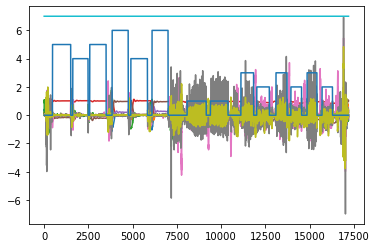

In [21]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:, i])

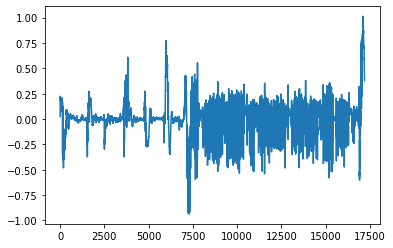

In [22]:
plt.plot(data[:,1])

In [23]:
data[:, -1]

array([0., 0., 0., ..., 0., 0., 0.])

## Plot Dataset Summary

In [24]:
# Count class representation

beh_names = dataset_metadata['label_names']
train_label_count = {name : 0 for name in beh_names}
val_label_count = {name : 0 for name in beh_names}
dev_label_count = {name : 0 for name in beh_names}
test_label_count = {name : 0 for name in beh_names}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        if clip_id in dataset_metadata['train_clip_ids']:
            train_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['val_clip_ids']:
            val_label_count[name] += counts[key]
            dev_label_count[name] += counts[key]
        elif clip_id in dataset_metadata['test_clip_ids']:
            test_label_count[name] += counts[key]

train_label_perc = {name : 0 for name in beh_names}
val_label_perc = {name : 0 for name in beh_names}
dev_label_perc = {name : 0 for name in beh_names}
test_label_perc = {name : 0 for name in beh_names}

for name in beh_names[1:]:
    train_label_perc[name] = train_label_count[name] / sum([train_label_count[j] for j in beh_names[1:]])
    val_label_perc[name] = val_label_count[name] / sum([val_label_count[j] for j in beh_names[1:]])
    dev_label_perc[name] = dev_label_count[name] / sum([dev_label_count[j] for j in beh_names[1:]])
    test_label_perc[name] = test_label_count[name] / sum([test_label_count[j] for j in beh_names[1:]])

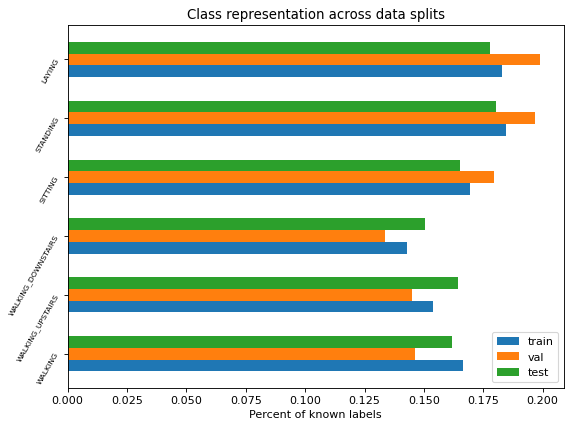

In [25]:
# Plot class representation

keys = np.arange(len(beh_names))[1:]
offset = 0.2
width = 0.2
plt.figure(figsize=(8, 6), dpi=80)

plt.barh(keys - offset, [train_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'train')
plt.barh(keys, [val_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'val')
plt.barh(keys + offset, [test_label_perc[beh_names[key]] for key in keys], height=width, align='center', label = 'test')
plt.title("Class representation across data splits")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.png')

plt.savefig(target_fp)
plt.show()

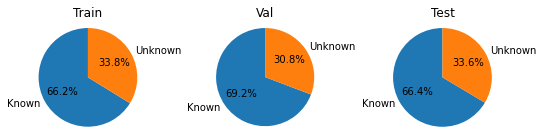

In [26]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,3, figsize = (9,2))
plt.title("blah")

ax[0].pie(train_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[0].set_title('Train')

ax[1].pie(val_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[1].set_title('Val')

ax[2].pie(test_sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax[2].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax[2].set_title('Test')

target_fp = os.path.join(formatted_data_dir, 'perc_known.png')

plt.savefig(target_fp)

plt.show()
